At the country level, the dynamics of the disease spread can be described using the same means as the dynamics of the incidence within the city. Individual cities will act as infected persons. In this situation, we have an obvious observable parameter responsible for the individual differences between cities — the size of the city (city population size). 

The country level disease spread is due to intercity visits. Let's assume that the number of people visiting a city is directly proportional to its size. This means that the relative (to the population size of the city) human influx does not depend on the size. Another assumption is that the social capacity to infect (roughly speaking activity) brought in by one host does not depend on the size of the city (although there are more opportunities for social activity in a larger city). Under these assumptions for any of the cities, the part of population infected by the visitors turns out to depend only on the proportion of the infected in those cities the visitors arriving from. Thus, the intercity disease spread becomes independent of cities sizes, and we get ordinary [SEIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model).

The model consists of four compartments $S$usceptible, $E$xposed,$I$nfectious, and $R$ecovered. Being infected by initial group of visitors a city moves from Susceptible to Recovered according to its individual internal  dynamics depended on the city population social heterohenity controlled by $v_s$ and inside city initial reproduction number $r_0$(see city level dinamics) and so on.   Assuming the set of cities to be fixed without the birth of new ones and the death of old ones, we obtain a system of SEIR equations:

$$
\begin{align}
\frac{dS}{dt} & = \beta I S \\[3pt]
\frac{dE}{dt} & = \beta I S - \frac{E}{\tau_E} \\[3pt]
\frac{dI}{dt} & = \frac{E}{\tau_E} - \frac{I}{\tau_I} \\[3pt]
R &=1-S-E-I
\end{align}
$$
We suggest the city get infected and becomes Exposed at the moment when the portion of its infected population becomes equal to some value $i_0$. Up to the mentioned moment we consider the dynamics of the city infected population as defined by external infection influx only, starting from the moment we consider the dynamics of the city infected population as defined by internal dynamics only.  We also suggest  all the parameters defining the internal dynamics are the same for all the cities. In this case the internal dynamics of each infected city is the same. Calculating the dynamisc for one of the cities we use some thresholds to divide the evolution of infection into Exposed,Infectious, and Recovered parts. That way we not only simplify the model and makes it more tractable, but infer the value of the $\tau_E$ and $\tau_I$ for the SEIR equations, and also average infected population portion $\mathcal{I}$ for the infected cities.

Let each of the cities have the same the visitors influx $w\in [0,1]$ (relative to its size) in a unit of time. The out flux value is the same but formed by arbitrary persons not necessary those in influx.  That means in a time unit $w\cdot I \cdot \mathcal{I}$ infected visitors visits a city, and as long as the city stays uninfected there is no out flux of infected persons. So for the city to get infected and become Exposed it takes 
$$
\frac{i_0}{w\cdot \mathcal{I} \cdot I }
$$
units of time, and probability to get infected at a unit of time is the inverse value 
$$
\frac{w\cdot \mathcal{I}\cdot I }{i_0}
$$
Thus, change in amount of Susceptible cities in $dt$ time is
$$
dS=-\frac{w\cdot \mathcal{I}\cdot I }{i_0}S dt
$$
or
$$
\frac{dS}{dt}=-\frac{w \mathcal{I}}{i_0}I S
$$
That means the $\beta$ coefficient in the SEIR equasions is given by:
$$
\beta=\frac{w \mathcal{I}}{i_0}
$$

Assuming everage citizen have one visits a year from its city we choose $w$ equal to 0.04.
It's time for some computation. First we calculate the pattern of a city infection dynamics based on HCS SIR model 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scst
import scipy.special as scsp
import scipy.interpolate as scint
from scipy.integrate import odeint
import matplotlib.ticker as ticker
from dataclasses import dataclass
plt.rc('legend',fontsize=12, handlelength=2) # using a size in points

plt.style.use('seaborn-darkgrid')

modeling_period=20.0
t_step=0.01
m_t=np.arange(0.0, modeling_period+t_step, t_step,dtype=np.float64)
n_steps=len(m_t)-1
def M(mu,v):return np.exp(mu+0.5*v)

In [2]:
def HCS_SIR(r0_0,I0,τ,vs0,vb0):
    '''
    Heterogeneous in Catching and Spreading
    SIR model
    '''
    def a_s(mus,C,vs):
        Cpvs=C+vs
        return M(mus,vs)*(1.0+Cpvs*(1.0+0.5*Cpvs))
    M0=M(0.0,vs0+vb0)
    a_s0=r0_0*a_s(0.0,0.0,vs0)/(r0_0-1.0+1.0/τ)
    α=r0_0/M0/a_s0
    
    def ODE(y,t):
        S,I,A,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        minus_αMA=-α*M(mus+mub,Cpvs+Cpvb)*A

        dS = minus_αMA*S
        dI = -dS - I
        dA= -a_s(mus,C,vs)*dS-A/τ
        dmus = minus_αMA*Cpvs
        dmub = minus_αMA*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI,dA, dmus,dmub,dC,dvs,dvb]
    
    A0=a_s0*I0
    y0=[1.0-I0,I0,A0,0.0,0.0,0.0,vs0,vb0]
    
    sol = odeint(ODE,y0, m_t).T
    S,I,A,mus,mub,C,vs,vb=sol
    dS=-ODE(sol,m_t)[0]
    R=1.0-S-I
    return S,I,R,dS

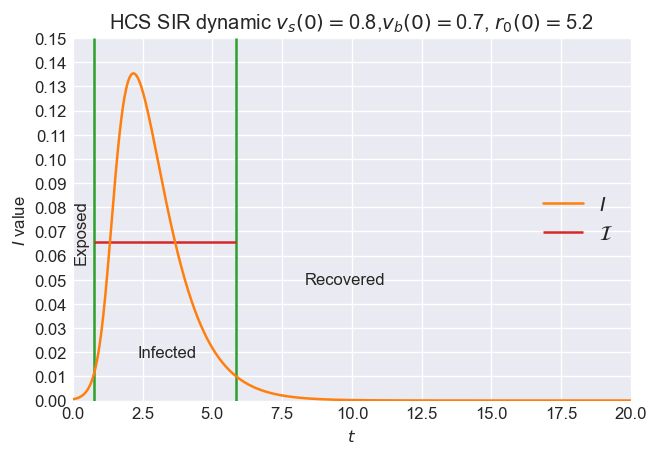

In [3]:
τ=0.4
vs0=0.8
vb0=0.7
r0_0=5.2
i0=0.0005
S,I,_,_= HCS_SIR(r0_0,i0,τ,vs0,vb0)

infected_threshold=0.01
infected_mask=I>infected_threshold
τ_E=t_step*np.sum(np.cumsum(infected_mask)==0)
infected=I[infected_mask]
τ_I=t_step*len(infected)
I_avr=np.mean(infected)
S_HCS=S# give distinct names to a variables
I_HCS=I

fig, ax = plt.subplots(dpi=120)

plt.plot(m_t, I,color='C1', label=f'$I$')
plt.vlines(x = [τ_E,τ_E+τ_I], ymin = 0, ymax = 0.15, 
           colors = 'C2')
plt.hlines(y = I_avr, xmin = τ_E, xmax = τ_E+τ_I, 
           colors = 'C3', label='$\mathcal{I}$')
plt.text(0.01, 0.07, "Exposed", rotation=90, verticalalignment='center')
plt.text(8.3, 0.05, "Recovered",  verticalalignment='center')
plt.text(2.3, 0.02, "Infected",  verticalalignment='center')
ax.set_ylim([0.0,.15])
ax.set_xlim([0.0,20])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.set_ylabel(f'$I$ value')
plt.legend(loc='center right')
plt.xlabel(f'$t$')
plt.title(f'HCS SIR dynamic $v_s(0)=${vs0},$v_b(0)=${vb0}, $r_0(0)=${r0_0}')

plt.show()
w=0.04
β=w*I_avr/i0
#print(f'β={β}')

Now we are ready for implememting country level SEIR model (CL SEIR).

In [4]:
def CL_SEIR(I0,β,τ_E,τ_I):
    '''
    Counry level
    SEIR model
    '''
    def ODE(y,t):
        S,E,I=y
        dS = -β*I*S
        dE = -dS-E/τ_E
        dI = E/τ_E - I/τ_I
        return [dS, dE, dI]
    
    y0=[1.0-I0,0.0,I0]
    
    sol = odeint(ODE,y0, m_t).T
    S,E,I=sol
    dS=-ODE(sol,m_t)[0]
    R=1.0-S-E-I
    return S,E,I,R,dS

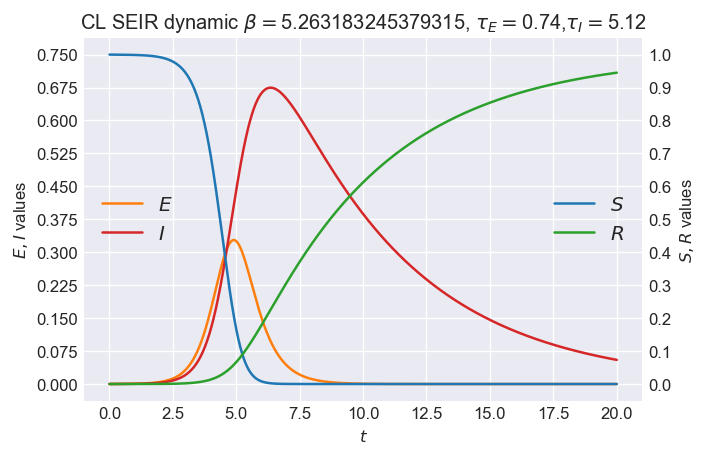

In [5]:
I0=0.0001
S,E,I,R,dS= CL_SEIR(I0,β,τ_E,τ_I)
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, E,color='C1', label=f'$E$')
plt.plot(m_t, I,color='C3', label=f'$I$')
#plt.plot(m_t, dS, color='C2', label=f'$|dS/dt|$') 
ax.set_ylim([-0.05*0.75,1.05*0.75])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.075))
ax.set_ylabel(f'$E,I$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, R,color='C2', label=f'$R$')
ax2.set_ylim([-0.05,1.05])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'CL SEIR dynamic $β=${β}, $τ_E=${τ_E},$τ_I=${τ_I}')
plt.show() 

The values S,E,I,R we get reflects the cities dynamics inside the country, not the country population dinamics. To get the country population dinamics we need to combine the cities dynamics and inside city dynamics via convolution. And finally  

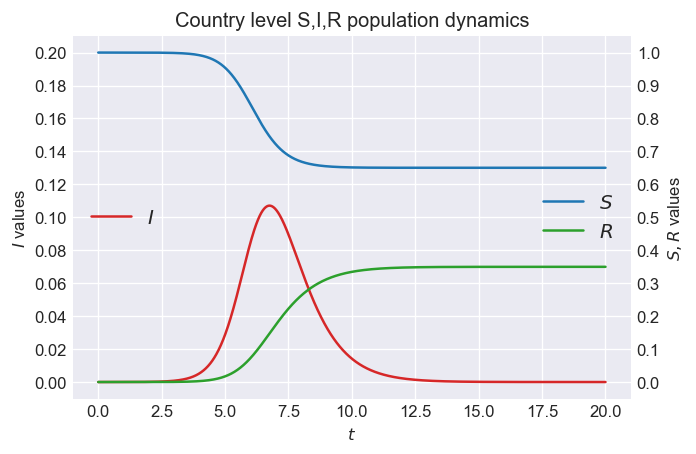

In [6]:
S_country_population=1.0-np.convolve(dS,1.0-S_HCS, mode='full')[:n_steps+1]*t_step
I_country_population=np.convolve(dS,I_HCS, mode='full')[:n_steps+1]*t_step
R_country_population=1.0-S_country_population-I_country_population
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, I_country_population,color='C3', label=f'$I$')
#plt.plot(m_t, dS, color='C2', label=f'$|dS/dt|$') 
ax.set_ylim([-0.05*0.2,1.05*0.2])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.set_ylabel(f'$I$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, S_country_population, color='C0', label=f'$S$')
plt.plot(m_t, R_country_population,color='C2', label=f'$R$')
ax2.set_ylim([-0.05,1.05])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.set_ylabel(f'$S,R$ values')
ax2.grid(False)

plt.legend(loc='center right')
plt.title(f'Country level S,I,R population dynamics')
plt.show() 

Yet, more realistic assumption is that number of people visiting a city is more than just proportional to its population size $z$ (in some countries, for example, only capitals have international airports so everyone travelling abroad have to visit the capitals) and, say, proportional to $z^{1+\theta}$. That makes large cities more vulnerable to infection, and we will get like SEIR model with probability for the city to get infected proportional to $z^\theta$.

It is known that the distribution of cities by population roughly corresponds to Zipf's law with exponent around 1. As continuous functions more preferable for the differential equations we will model the cities size distribution as a continuous random variable $Z$. To this means we use bounded Pareto distribution with support $[l,h]$ and PDF
$$f(z)=\frac{lh}{h-l}z^{-2}$$
where l and h is the population size limits (as a part of the whole country population) for smallest and largest cities , for example 1.0e-6 and 0.05. If the total number of cities is $N$, then in the interval $[a,b]\in [l,h]$ it will be 
$$N\int_a^bf(z)dz$$ 
cities with population
$$N\int_a^bzf(z)dz=N\frac{lh}{h-l}(\ln(b)-\ln(a))$$
For the entire interval $[l, h]$, we must get the entire population, which we consider equal to 1. So, having $l$ and $h$ chosen, the total number of cities $N$ must satisfy
$$N\frac{lh}{h-l}(\ln(h)-\ln(l))=1$$
or
$$N=\frac{h-l}{lh(\ln(h)-\ln(l))}$$